<a href="https://colab.research.google.com/github/TechnoVishalGirase/Step_presentation_2/blob/rkdhakal-patch-1/EcoEye_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [15]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [11]:
image_dir=Path('/content/drive/MyDrive/ECOEYE/Datasets')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)


In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [16]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3848 validated image filenames belonging to 4 classes.
Found 961 validated image filenames belonging to 4 classes.
Found 1203 validated image filenames belonging to 4 classes.


In [17]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [19]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [26]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/bird_classification/20240327-223736
Epoch 1/5
121/121 [==============================] - 1167s 10s/step - loss: 1.7856 - accuracy: 0.5606 - val_loss: 0.2584 - val_accuracy: 0.9188 - lr: 1.0000e-04
Epoch 2/5
121/121 [==============================] - 390s 3s/step - loss: 0.6366 - accuracy: 0.7788 - val_loss: 0.1982 - val_accuracy: 0.9417 - lr: 1.0000e-04
Epoch 3/5
121/121 [==============================] - 382s 3s/step - loss: 0.4245 - accuracy: 0.8516 - val_loss: 0.1593 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 4/5
121/121 [==============================] - 391s 3s/step - loss: 0.3244 - accuracy: 0.8916 - val_loss: 0.1570 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 5/5
121/121 [==============================] - 409s 3s/step - loss: 0.2792 - accuracy: 0.9096 - val_loss: 0.1539 - val_accuracy: 0.9594 - lr: 1.0000e-04


In [ ]:
# results = model.evaluate(test_images, verbose=0)

# print("    Test Loss: {:.5f}".format(results[0]))
# print("Test Accuracy: {:.2f}%".format(results[1] * 100))

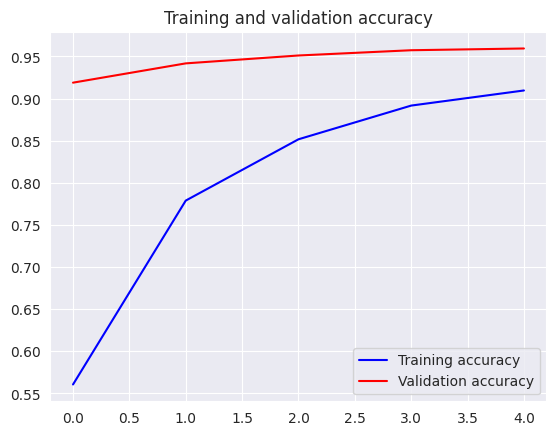

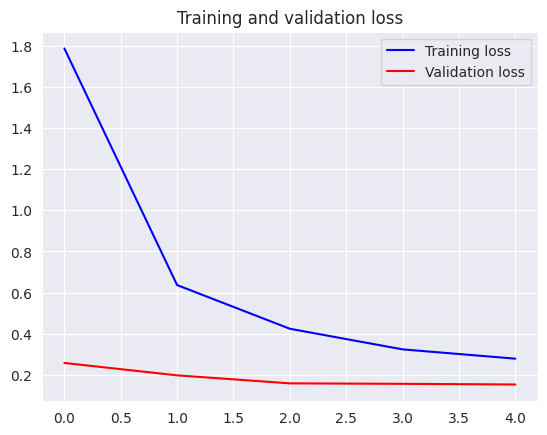

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

38/38 [==============================] - 99s 3s/step
The first 5 predictions: ['Myna', 'Golden Cheeked Warbler', 'Golden Cheeked Warbler', 'Albatross', 'Myna']


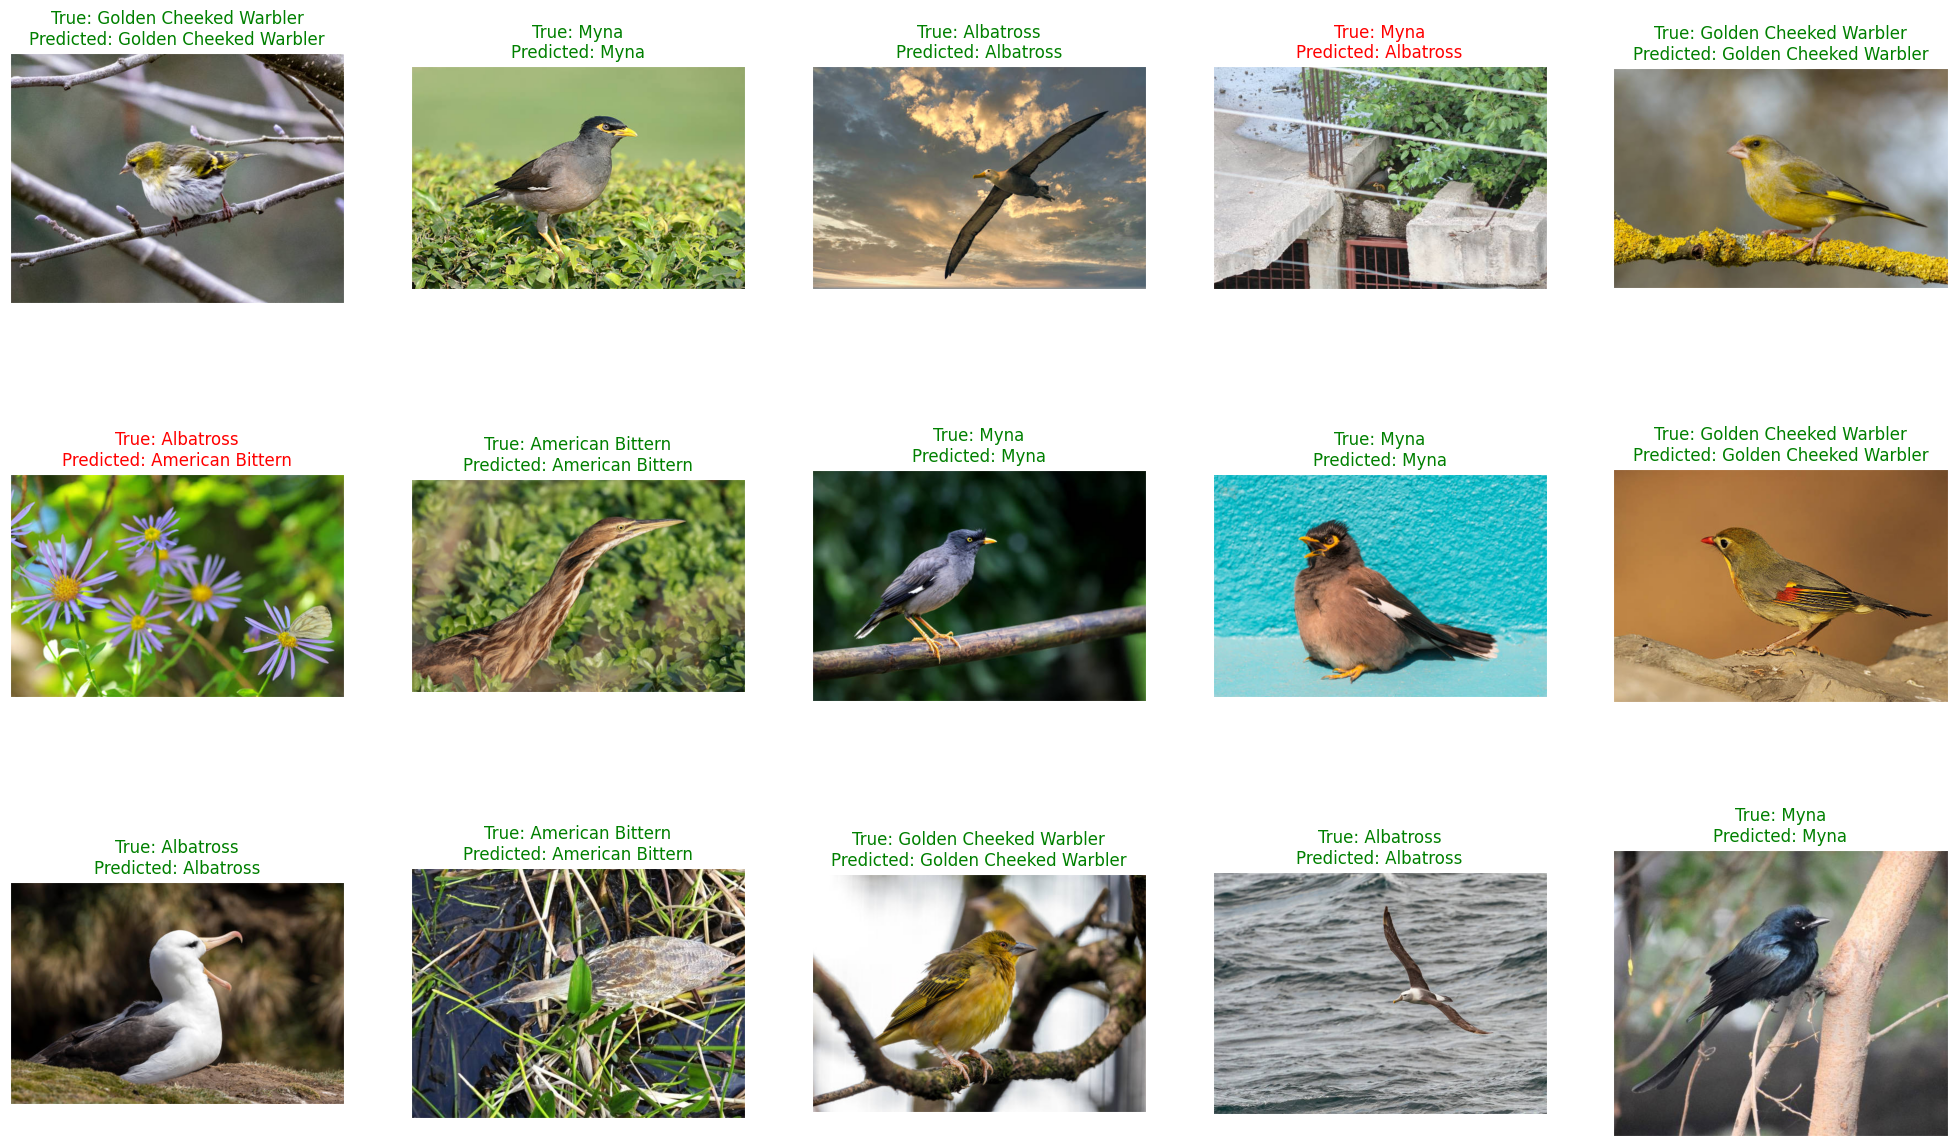

<Figure size 640x480 with 0 Axes>

In [32]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()